### > Setup

In [1]:
import boto3
import sagemaker
import json
from sagemaker.utils import name_from_base
from diffusers.utils import load_image, make_image_grid
import cv2
import base64
import io
import numpy as np
from PIL import Image

boto3_session=boto3.session.Session()

smr = boto3_session.client("sagemaker-runtime") # sagemaker runtime client for invoking the endpoint
sm = boto3_session.client("sagemaker") 
s3_rsr = boto3_session.resource("s3")
role = sagemaker.get_execution_role()

sess = sagemaker.session.Session(boto3_session, sagemaker_client=sm, sagemaker_runtime_client=smr)  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # sagemaker session for interacting with different AWS APIs
region = sess._region_name  # region name of the current SageMaker Studio environment
s3_prefix = "sdxl-1.0"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### > download model from huggingface and build the model.tar.gz file

In [2]:
from pathlib import Path
import tarfile, os
import shutil
from huggingface_hub import snapshot_download

model_id = [
    "madebyollin/sdxl-vae-fp16-fix",
    "diffusers/controlnet-canny-sdxl-1.0",
    "latent-consistency/lcm-sdxl",
    "stabilityai/stable-diffusion-xl-base-1.0"
]

In [3]:
technique = "canny"
os.makedirs(f'compressed/{technique}/',exist_ok=True)

In [4]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [5]:
!find . | grep -E "(/__pycache__$|\.pyc$|\.pyo$)" | xargs rm -rf

In [6]:
# Creating a tarfile to to compress our model to a `tar.gz` format
# as required by SageMaker
tar = tarfile.open(
    f"compressed/{technique}/{technique}.tar.gz",
    "w:gz",
    compresslevel=2
)

for ids in model_id:
    # Create local dir to download models into
    model_tar_dir = Path(ids.split("/")[-1])
    if model_tar_dir.exists():
        shutil.rmtree(str(model_tar_dir))
    model_tar_dir.mkdir(exist_ok=True)

    # Download model from Hugging Face into model_dir and adding
    # to the tarfile then deleting from local directory
    snapshot_download(
        ids, local_dir=str(model_tar_dir), local_dir_use_symlinks=False
    )
    tar.add(str(model_tar_dir), arcname=model_tar_dir)
    # !rm -r {str(model_tar_dir)}
    print(f"{model_tar_dir} archive complete")
# Adding the inference scripts and requirements file to the tarfile
tar.add(f"code/", arcname="code")
tar.close()

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

images/activation-magnitudes.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

images/orig-fp16.png:   0%|          | 0.00/3.13k [00:00<?, ?B/s]

fix-fp16.png:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

fix-fp32.png:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

sdxl_vae.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

orig-fp32.png:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

sdxl-vae-fp16-fix archive complete


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.58k [00:00<?, ?B/s]

out_bird.png:   0%|          | 0.00/6.94M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

out_hug_lab_7.png:   0%|          | 0.00/1.97M [00:00<?, ?B/s]

out_room.png:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

out_couple.png:   0%|          | 0.00/7.29M [00:00<?, ?B/s]

out_tornado.png:   0%|          | 0.00/8.51M [00:00<?, ?B/s]

out_women.png:   0%|          | 0.00/7.59M [00:00<?, ?B/s]

controlnet-canny-sdxl-1.0 archive complete


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

image.png:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

lcm-sdxl archive complete


Fetching 57 files:   0%|          | 0/57 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/8.67k [00:00<?, ?B/s]

01.png:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

pipeline.png:   0%|          | 0.00/80.2k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

comparison.png:   0%|          | 0.00/130k [00:00<?, ?B/s]

LICENSE.md:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

sd_xl_base_1.0_0.9vae.safetensors:   0%|          | 0.00/6.94G [00:00<?, ?B/s]

sd_xl_base_1.0.safetensors:   0%|          | 0.00/6.94G [00:00<?, ?B/s]

(…)d_xl_offset_example-lora_1.0.safetensors:   0%|          | 0.00/49.6M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/492M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/493M [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

model.onnx_data:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

diffusion_flax_model.msgpack:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/7.29M [00:00<?, ?B/s]

model.onnx_data:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

diffusion_flax_model.msgpack:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_1_0/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_decoder/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/198M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/992k [00:00<?, ?B/s]

vae_encoder/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/137M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/137M [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/850k [00:00<?, ?B/s]

stable-diffusion-xl-base-1.0 archive complete


In [7]:
model_s3_path = f"s3://{bucket}/{s3_prefix}/models/{technique}.tar.gz"
!aws s3 cp ./compressed/{technique}/{technique}.tar.gz {model_s3_path}

upload: compressed/canny/canny.tar.gz to s3://sagemaker-us-east-1-376678947624/sdxl-1.0/models/canny.tar.gz


### > Deploy to SageMaker endpoint

In [8]:
from sagemaker.huggingface.model import HuggingFaceModel

image_uri = f"763104351884.dkr.ecr.{region}.amazonaws.com/huggingface-pytorch-inference:2.0.0-transformers4.28.1-gpu-py310-cu118-ubuntu20.04"

huggingface_model = HuggingFaceModel(
    model_data=model_s3_path, # path to your trained sagemaker model 
    role=role,                # iam role with permissions to create an Endpoint
    py_version="py39",        # python version of the DLC
    image_uri=image_uri,      # sagemaker container image uri
    env={
        "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
        "SAGEMAKER_PROGRAM": "inference.py",
        "SAGEMAKER_REGION": region,
    },
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [9]:
endpoint_name = f"{name_from_base('sdxl-1-0')}-endpoint"

predictor = huggingface_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type= "ml.g5.2xlarge",
    model_data_download_timeout=3600
)

-----------------------------------!

### Invoke SageMaker endpoint

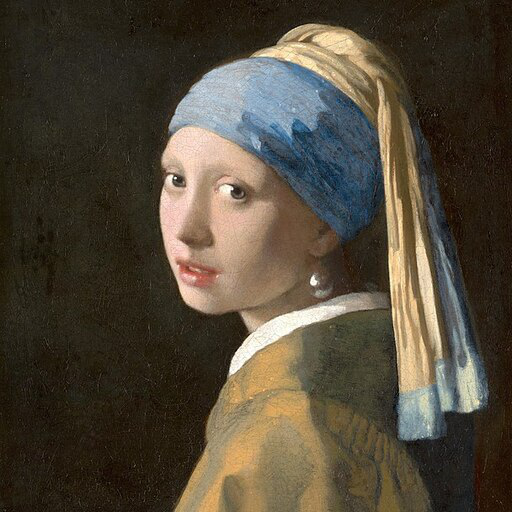

In [10]:
prompt = "Mystical fairy in real, magic, 4k picture, high quality"
negative_prompt = "extra digit, fewer digits, cropped, worst quality, low quality, glitch, deformed, mutated, ugly, disfigured"
seed = 0
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

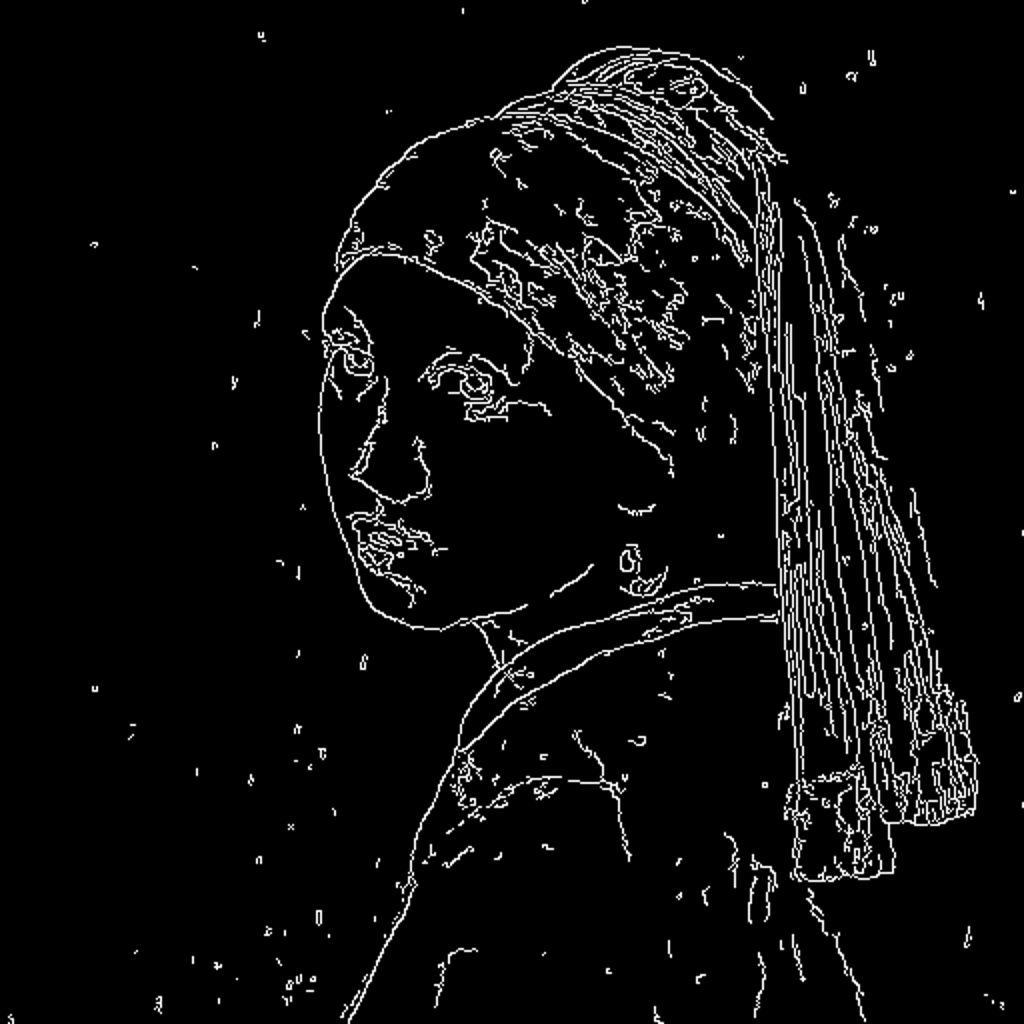

In [11]:
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image).resize((1024, 1024))

canny_image

In [12]:
def _encode(image):
    img = image
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format="PNG")
    img_byte_arr = img_byte_arr.getvalue()
    img_byte_arr = base64.b64encode(img_byte_arr).decode()
    return img_byte_arr

def _decode(image):
    image = base64.b64decode(image)
    image = Image.open(io.BytesIO(image))
    return image

In [17]:
response_model = smr.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "image": _encode(canny_image),
                "prompt": prompt,
                "negative_prompt": negative_prompt,
                "seed": seed,
                "num_inference_steps": 4,
                "controlnet_conditioning_scale": 0.8,
                "guidance_scale": 1.5,
            }
        ),
        ContentType="application/json",
    )

In [18]:
from io import BytesIO

output_image = Image.open(
    BytesIO(
            base64.b64decode(
                json.loads(response_model["Body"].read().decode("utf8"))["output_image"]
            )
        )
)

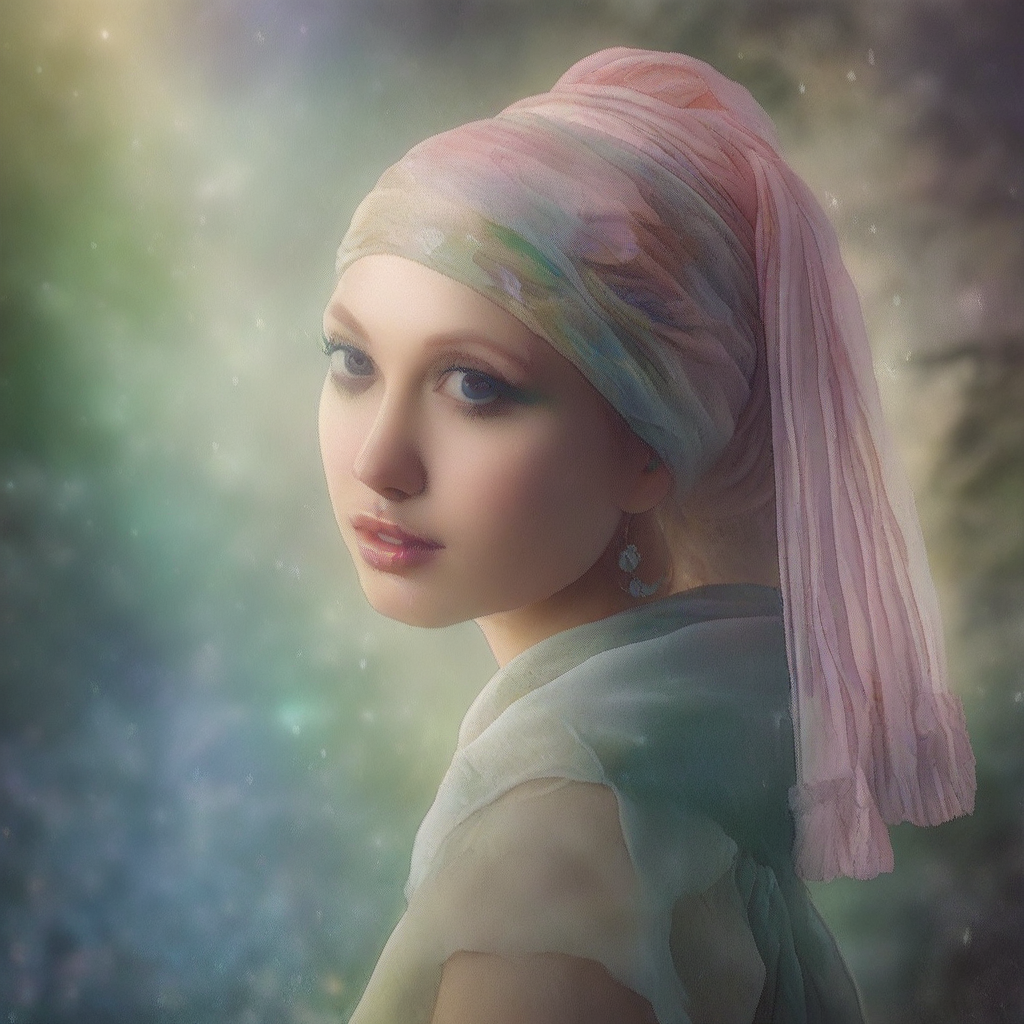

In [19]:
output_image

In [35]:
predictor.delete_endpoint()